In [2]:
import os
import sys
import random
import time
import argparse
sys.path.append('../')

import pickle
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

from models.dataset import Dataset
from models.interaction_network import InteractionNetwork
from models.graph import Graph, save_graphs, load_graph

In [3]:
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

In [3]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

In [8]:
def plot_rz(X, Ri, Ro, y, out, disc, save_fig=False, filename="rz.png"):
    X = np.array(X)
    out = np.array(out)
    feats_o = np.matmul(Ro.transpose(), X)
    feats_i = np.matmul(Ri.transpose(), X)

    fig = plt.figure(dpi=1000)
    for i in range(len(X)):        
        plt.scatter(X[i][2], X[i][0], c='silver', linewidths=0, marker='s', s=8)

    track_segs_o = feats_o[y>0.5]
    track_segs_i = feats_i[y>0.5]
    
    for i in range(len(track_segs_o)):
        plt.plot((track_segs_o[i][2], track_segs_i[i][2]),
                 (track_segs_o[i][0], track_segs_i[i][0]),
                  marker='o', ls='-', color='blue', lw=0.2, ms=0.1, alpha=1)
    
    false_edges_o = feats_o[y<0.5]
    false_edges_i = feats_i[y<0.5]
    for i in range(len(false_edges_o)):
        plt.plot((false_edges_o[i][2], false_edges_i[i][2]),
                 (false_edges_o[i][0], false_edges_i[i][0]),
                  marker='o', ls='-', color='black', lw=0.1, ms=0.1, alpha=0.5)

        
    plt.ylabel("r [m]")
    plt.xlabel("z [m]")
    if (save_fig): plt.savefig(filename, dpi=1200)
    plt.show()

In [9]:
# trained models for the paper 
model_dir = '/tigress/jdezoort/IN_paper_models/'
models = os.listdir('/tigress/jdezoort/IN_paper_models/')
model_paths = [model_dir+model for model in models]
models_by_pt = {model.split('.')[0].split('_')[-1].strip('GeV'): model for model in model_paths}

# initial discriminants (won't matter in the end)
discs = {'2': 0.346, '1p5': 0.38, '1': 0.225, '0p75': 0.2033, '0p6': 0.2}
device = "cpu"

In [32]:
pt = '2'
model = models_by_pt[pt]
print('...evaluating', model)
disc = discs[pt]
interaction_network = InteractionNetwork(3, 4, 4)
interaction_network.load_state_dict(torch.load(model, map_location=torch.device('cpu')))
interaction_network.eval()

...evaluating /tigress/jdezoort/IN_paper_models/train1_40hu_heptrkx_plus_epoch60_2GeV.pt


InteractionNetwork(
  (phi_R1): RelationalModel(
    (layers): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=4, bias=True)
    )
  )
  (phi_R2): RelationalModel(
    (layers): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (phi_O): ObjectModel(
    (layers): Sequential(
      (0): Linear(in_features=7, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=3, bias=True)
    )
  )
)

In [33]:
construction = 'heptrkx_plus'
graph_indir = "../../hitgraphs_2/{}_{}/".format(construction, pt)
print('...sampling graphs from:', graph_indir)
graph_files = np.array(os.listdir(graph_indir))
train_2_mask = [(int(graph_file.split("00000")[1].split("_")[0]) > 2820)
                for graph_file in graph_files]
graph_files = graph_files[train_2_mask]
n_graphs = len(graph_files)
    
# randomly partition the graphs into 100 validation and 600 testing graphs 
IDs = np.arange(n_graphs)
np.random.shuffle(IDs)
        
partition = {'val': graph_files[IDs[500:600]],
             'test':  graph_files[IDs[1000:1500]]}
        
# create a test dataloader 
params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}
test_set = Dataset(graph_indir, partition['test']) 
test_loader = torch.utils.data.DataLoader(test_set, **params)

...sampling graphs from: ../../hitgraphs_2/heptrkx_plus_2/


In [34]:
good_eff, tight_eff, exa_eff = [], [], []
with torch.no_grad():
    counter = 0
    for data, target in test_loader:
        
        # grab data and targets 
        X, Ra = data['X'].float().to(device), data['Ra'].float().to(device)
        Ri, Ro = data['Ri'].float().to(device), data['Ro'].float().to(device)
        pids = target['pid'][0].to(device)
        target = target['y'].to(device)
        
        # inference, loss calculation
        output = interaction_network(X, Ra.float(), Ri.float(), Ro.float())
        test_loss = F.binary_cross_entropy(output.squeeze(2), target,
                                           reduction='mean').item()
        accuracy = torch.sum(((target==1).squeeze() &
                              (output>disc).squeeze()) |
                             ((target==0).squeeze() &
                              (output<disc).squeeze())).float()/target.shape[1]

        #print('loss={}, acc={}'.format(test_loss, accuracy))

        # shape up output, calculate true edges 
        output = output.squeeze()
        true_edges = (output>disc).squeeze()
        probs = torch.transpose(torch.unsqueeze(output, dim=0), 0, 1)
        
        # count hits per pid in each event, add indices to hits
        n_particles = len(np.unique(pids))
        pid_counts = {p.item(): torch.sum(pids==p).item() for p in pids}
        denominator = np.sum(np.fromiter(pid_counts.values(), dtype=int) > 1)
        
        pid_label_map = {p.item(): -5 for p in pids}
        hit_idx = torch.unsqueeze(torch.arange(X[0].shape[1]), dim=0)
        X = torch.cat((hit_idx.float(), X[0]), dim=0)
    
        # separate segments into incoming and outgoing hit positions 
        feats_o = torch.matmul(Ro[0], torch.transpose(X, dim0=0, dim1=1))
        feats_o = torch.cat((feats_o, probs), dim=1)
        feats_o = feats_o[true_edges]
        feats_i = torch.matmul(Ri[0], torch.transpose(X, dim0=0, dim1=1))
        feats_i = torch.cat((feats_i, probs), dim=1)
        feats_i = feats_i[true_edges]
        
        # geometric quantities --> distance calculation 
        r_o, phi_o, z_o = feats_o[:,1], feats_o[:,2], feats_o[:,3]
        eta_o = calc_eta(r_o, z_o)
        r_i, phi_i, z_i = feats_i[:,1], feats_i[:,2], feats_i[:,3]
        eta_i = calc_eta(r_i, z_i)
        dphi, deta = calc_dphi(phi_o, phi_i), eta_i-eta_o
        distances = torch.sqrt((r_i*torch.cos(np.pi*phi_i) - r_o*torch.cos(np.pi*phi_o))**2 +
                               (r_i*torch.sin(np.pi*phi_i) - r_i*torch.sin(np.pi*phi_i))**2 +
                               (z_i-z_o)**2)
        #distances = torch.sqrt(dphi**2 + deta**2)
        
        dist_matrix = 10*torch.ones(X.shape[1], X.shape[1])
        for i in range(dist_matrix.shape[0]): dist_matrix[i][i]=0
            
        for h in range(len(feats_i)):
            dist_matrix[int(feats_o[h][0])][int(feats_i[h][0])] = distances[h]
            
        # run DBScan
        eps_dict = {'2': 0.40, '1p5': 0.4, '1': 0.4, '0p75': 0.4, '0p6': 0.4}
        eps, min_pts = eps_dict[pt], 1
        clustering = DBSCAN(eps=eps, min_samples=min_pts,
                            metric='precomputed').fit(dist_matrix)
        labels = clustering.labels_
        
        # count reconstructed particles from hit clusters 
        good_clusters, tight_clusters, exa_clusters = 0, 0, 0
        for label in np.unique(labels):  
            if label<0: continue # ignore noise 
                
            # grab pids corresponding to hit cluster labels
            label_pids = pids[labels==label]
            selected_pid = np.bincount(label_pids).argmax() # most frequent pid in cluster
            
            # fraction of hits with the most common pid 
            n_reco_selected = len(label_pids[label_pids==selected_pid])
            hit_fraction = n_reco_selected/len(label_pids)
                
            #previously_found = pid_label_map[selected_pid] > -1
            pid_label_map[selected_pid] = label
            if hit_fraction > 0.99:
                good_clusters += 1
                #if not previously_found: good_clusters+=1
                pid = label_pids[0].item()
                if pid_counts[pid] == len(label_pids):
                    tight_clusters += 1
            if hit_fraction > 0.5:
                true_counts = pid_counts[selected_pid]
                if n_reco_selected/true_counts > 0.5:
                    exa_clusters += 1

        good_eff.append(good_clusters/(len(np.unique(labels))-1))
        tight_eff.append(tight_clusters/n_particles)
        exa_eff.append(exa_clusters/n_particles)
        #print("GOOD: {}/{}={}".format(good_clusters, n_particles, good_clusters/n_particles))
        #print("TIGHT: {}/{}={}".format(tight_clusters, n_particles, tight_clusters/n_particles))
        #print("EXA: {}/{}={}".format(exa_clusters, n_particles, exa_clusters/n_particles))
        counter += 1
        if (counter > 100): break
        
        del X
        del Ri
        del Ro
        del Ra
        del target

print("Good Eff: {}+/-{}", np.mean(good_eff), np.std(good_eff))
print("Tight Eff: {}+/-{}", np.mean(tight_eff), np.std(tight_eff))
print("Exa Eff: {}+/-{}", np.mean(exa_eff), np.std(exa_eff))

Good Eff: {}+/-{} 0.9966491883680958 0.006559843089193328
Tight Eff: {}+/-{} 0.9361430153889063 0.015847555533868928
Exa Eff: {}+/-{} 0.9797442301618968 0.010255893727419212


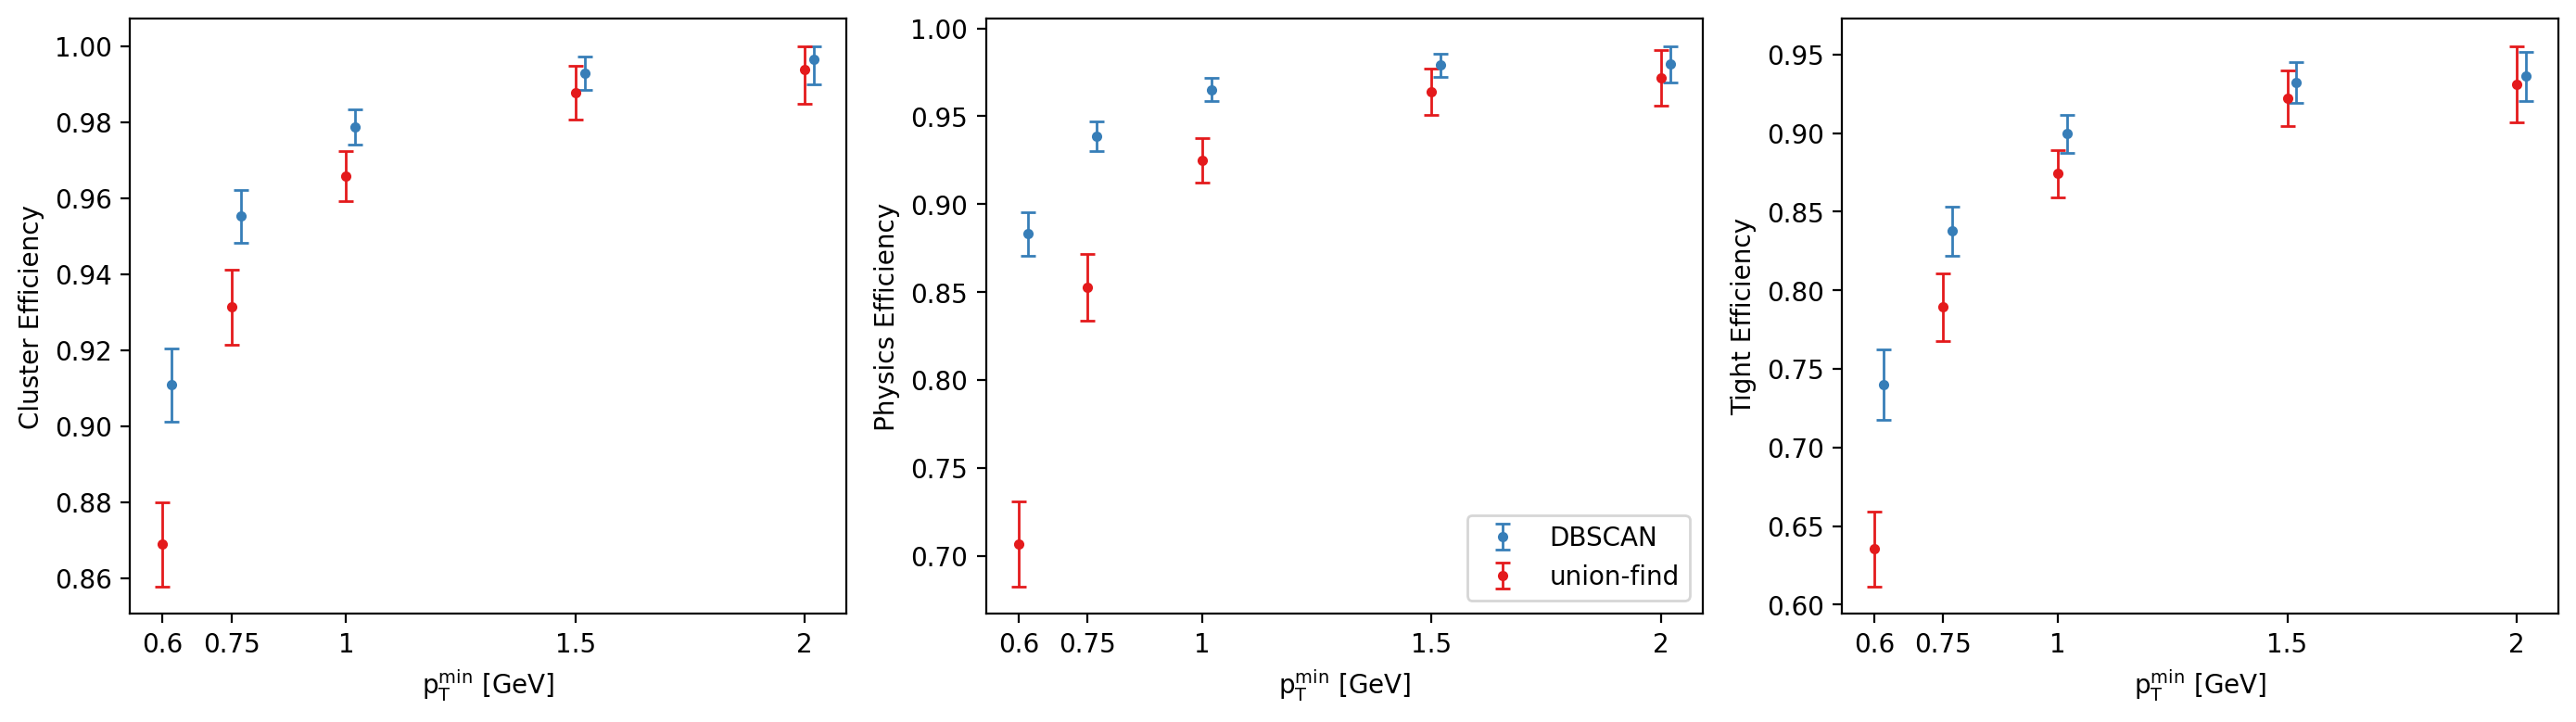

In [4]:
pt = np.array([2,1.5,1,0.75,0.6])
good_effs = {
    'db': [0.9966, 0.9928, 0.9787, 0.9552, 0.9109],
    'uf': [0.9939, 0.9877, 0.9658, 0.9313, 0.8690]
}
good_effs_errs = {
    'db': [[0.0066, 0.0043, 0.0047, 0.0069, 0.0096],
           [0.0034, 0.0043, 0.0047, 0.0069, 0.0096]],
    'uf': [[0.0091, 0.0071, 0.0066, 0.0098, 0.0111],
           [0.0061, 0.0071, 0.0066, 0.0098, 0.0111]]
}
tight_effs = {
    'db': [0.9361, 0.9322, 0.8995, 0.8376, 0.7399],
    'uf': [0.9310, 0.9221, 0.8742, 0.7892, 0.6353]
}
tight_effs_errs = {
    'db': [0.0158, 0.0132, 0.0119, 0.0157, 0.0226],
    'uf': [0.0244, 0.0177, 0.0149, 0.0214, 0.0237]
}
exa_effs = {
    'db': [0.9797, 0.9790, 0.9652, 0.9386, 0.8832],
    'uf': [0.9719, 0.9638, 0.9248, 0.8527, 0.7068]
}
exa_effs_errs = {
    'db': [0.0103, 0.0068, 0.0064, 0.0085, 0.0124],
    'uf': [0.0160, 0.0133, 0.0127, 0.0191, 0.0242]
}


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), dpi=200)
axs[0].errorbar(pt+0.02, good_effs['db'], yerr=good_effs_errs['db'],
             color=colors[0], label='DBSCAN',
             marker='.', lw=1, ls='', capsize=3)
axs[2].errorbar(pt+0.02, tight_effs['db'], yerr=tight_effs_errs['db'],
             color=colors[0], label='DBSCAN',
             marker='.', lw=1, ls='', capsize=3)
axs[1].errorbar(pt+0.02, exa_effs['db'], yerr=exa_effs_errs['db'],
             color=colors[0], label='DBSCAN',
             marker='.', lw=1, ls='', capsize=3)
axs[0].errorbar(pt, good_effs['uf'], yerr=good_effs_errs['uf'],
             color=colors[7], label='union-find',
             marker='.', lw=1, ls='', capsize=3)
axs[2].errorbar(pt, tight_effs['uf'], yerr=tight_effs_errs['uf'],
             color=colors[7], label='union-find',
             marker='.', lw=1, ls='', capsize=3)
axs[1].errorbar(pt, exa_effs['uf'], yerr=exa_effs_errs['uf'],
             color=colors[7], label='union-find',
             marker='.', lw=1, ls='', capsize=3)

axs[0].set_xticks([0.6, 0.75, 1, 1.5, 2])
axs[0].set_xticklabels([0.6, 0.75, 1, 1.5, 2])
axs[1].set_xticks([0.6, 0.75, 1, 1.5, 2])
axs[1].set_xticklabels([0.6, 0.75, 1, 1.5, 2])
axs[2].set_xticks([0.6, 0.75, 1, 1.5, 2])
axs[2].set_xticklabels([0.6, 0.75, 1, 1.5, 2])
axs[0].set_ylabel("Cluster Efficiency")
axs[2].set_ylabel("Tight Efficiency")
axs[1].set_ylabel("Physics Efficiency")
axs[0].set_xlabel("$p_T^{min}$ [GeV]")
axs[1].set_xlabel("$p_T^{min}$ [GeV]")
axs[2].set_xlabel("$p_T^{min}$ [GeV]")
axs[1].legend(loc='lower right')
plt.tight_layout()
plt.savefig('tracking_effs.pdf', format='PDF', bbox_inches='tight')
plt.show()

In [4]:
pt_cut = 2
use_cuda = False
construction = 'heptrkx_plus'
epoch = 48
disc = 0.3
model = "../trained_models/train1_40hu_{}_epoch{}_{}GeV.pt".format(construction, epoch, pt_cut)
print("model={0}".format(model))

# load in test graph paths
graph_indir = "../../hitgraphs_2/{}_{}/".format(construction, pt_cut)
graph_files = np.array(os.listdir(graph_indir))

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 1}
test_kwargs = {'batch_size': 1}

n_graphs = len(graph_files)
IDs = np.arange(n_graphs)
#np.random.shuffle(IDs)
partition = {'test':  graph_files[IDs[1000:1400]]}

params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}
test_set = Dataset(graph_indir, partition['test'])
test_loader = torch.utils.data.DataLoader(test_set, **params)

interaction_network = InteractionNetwork(3, 4, 4)
interaction_network.load_state_dict(torch.load(model, map_location=torch.device('cpu')))
interaction_network.eval()

model=../trained_models/train1_40hu_heptrkx_plus_epoch48_1GeV.pt


InteractionNetwork(
  (phi_R1): RelationalModel(
    (layers): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=4, bias=True)
    )
  )
  (phi_R2): RelationalModel(
    (layers): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (phi_O): ObjectModel(
    (layers): Sequential(
      (0): Linear(in_features=7, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=3, bias=True)
    )
  )
)

In [16]:
good_eff, tight_eff = [], []
with torch.no_grad():
    counter = 0
    for data, target in test_loader:
        
        # grab data and targets 
        X, Ra = data['X'].float().to(device), data['Ra'].float().to(device)
        Ri, Ro = data['Ri'].float().to(device), data['Ro'].float().to(device)
        pids = target['pid'][0].to(device)
        target = target['y'].to(device)
        
        # inference, loss calculation
        output = interaction_network(X, Ra.float(), Ri.float(), Ro.float())
        test_loss = F.binary_cross_entropy(output.squeeze(2), target,
                                           reduction='mean').item()
        accuracy = torch.sum(((target==1).squeeze() &
                              (output>disc).squeeze()) |
                             ((target==0).squeeze() &
                              (output<disc).squeeze())).float()/target.shape[1]

        print('loss={}, acc={}'.format(test_loss, accuracy))

        # shape up output, calculate true edges 
        output = output.squeeze()
        true_edges = (output>disc).squeeze()
        probs = torch.transpose(torch.unsqueeze(output, dim=0), 0, 1)
        
        # count hits per pid in each event, add indices to hits
        n_particles = len(np.unique(pids))
        pid_counts = {p.item(): torch.sum(pids==p).item() for p in pids}
        pid_label_map = {p.item(): -5 for p in pids}
        hit_idx = torch.unsqueeze(torch.arange(X[0].shape[1]), dim=0)
        X = torch.cat((hit_idx.float(), X[0]), dim=0)
    
        # separate segments into incoming and outgoing hit positions 
        feats_o = torch.matmul(Ro[0], torch.transpose(X, dim0=0, dim1=1))
        feats_o = torch.cat((feats_o, probs), dim=1)
        feats_o = feats_o[true_edges]
        feats_i = torch.matmul(Ri[0], torch.transpose(X, dim0=0, dim1=1))
        feats_i = torch.cat((feats_i, probs), dim=1)
        feats_i = feats_i[true_edges]
        
        # geometric quantities --> distance calculation 
        r_o, phi_o, z_o = feats_o[:,1], feats_o[:,2], feats_o[:,3]
        eta_o = calc_eta(r_o, z_o)
        r_i, phi_i, z_i = feats_i[:,1], feats_i[:,2], feats_i[:,3]
        eta_i = calc_eta(r_i, z_i)
        dphi, deta = calc_dphi(phi_o, phi_i), eta_i-eta_o
        distances = torch.sqrt((r_i*torch.cos(np.pi*phi_i) - r_o*torch.cos(np.pi*phi_o))**2 +
                               (r_i*torch.sin(np.pi*phi_i) - r_i*torch.sin(np.pi*phi_i))**2 +
                               (z_i-z_o)**2)
        #distances = torch.sqrt(dphi**2 + deta**2)
        
        dist_matrix = 10*torch.ones(X.shape[1], X.shape[1])
        for h in range(len(feats_i)):
            dist_matrix[int(feats_o[h][0])][int(feats_i[h][0])] = distances[h]
            
        # run DBScan
        eps, min_pts = 0.38, 1
        clustering = DBSCAN(eps=eps, min_samples=min_pts,
                            metric='precomputed').fit(dist_matrix)
        labels = clustering.labels_
        
        # count reconstructed particles from hit clusters 
        good_clusters, tight_clusters, exa_clusters = 0, 0, 0
        for label in np.unique(labels):  
            if label==-1: continue # ignore noise 
                
            # grab pids corresponding to hit cluster labels
            label_pids = pids[labels==label]
            selected_pid = np.bincount(label_pids).argmax() # most frequent pid in cluster
            
            # fraction of hits with the most common pid 
            n_reco_selected = len(label_pids[label_pids==selected_pid])
            hit_fraction = n_reco_selected/len(label_pids)
                
            pid_label_map[main_pid] = label
            if hit_fraction > 0.99:
                good_clusters+=1
                pid = label_pids[0].item()
                if pid_counts[pid] == len(label_pids):
                    tight_clusters += 1
            if hit_fraction > 0.5:
                true_counts = pid_counts[selected_pid]
                if n_reco_selected/true_counts > 0.5:
                    exa_clusters += 1

        good_eff.append(good_clusters/n_particles)
        tight_eff.append(tight_clusters/n_particles)
        print("GOOD: {}/{}={}".format(good_clusters, n_particles, good_clusters/n_particles))
        print("TIGHT: {}/{}={}".format(tight_clusters, n_particles, tight_clusters/n_particles))
        print("EXA: {}/{}={}".format(exa_clusters, n_particles, exa_clusters/n_particles))
        counter += 1
        if (counter > 100): break

print("Good Eff: {}+/-{}", np.mean(good_eff), np.std(good_eff))
print("Tight Eff: {}+/-{}", np.mean(tight_eff), np.std(tight_eff))


loss=0.00597598310559988, acc=0.9972600340843201
GOOD: 1197/1240=0.9653225806451613
TIGHT: 1088/1240=0.8774193548387097
EXA: 1171/1240=0.9443548387096774
loss=0.006478280760347843, acc=0.9972885847091675
GOOD: 1301/1372=0.9482507288629738
TIGHT: 1181/1372=0.8607871720116618
EXA: 1291/1372=0.9409620991253644
loss=0.005910695064812899, acc=0.997617244720459
GOOD: 1279/1321=0.9682059046177138
TIGHT: 1158/1321=0.8766086298258895
EXA: 1244/1321=0.9417108251324754
loss=0.005352388136088848, acc=0.9980005621910095
GOOD: 949/980=0.9683673469387755
TIGHT: 854/980=0.8714285714285714
EXA: 915/980=0.9336734693877551
loss=0.009075879119336605, acc=0.9962854385375977
GOOD: 962/997=0.9648946840521565
TIGHT: 848/997=0.8505516549648947
EXA: 936/997=0.9388164493480441
loss=0.004749712534248829, acc=0.9981459379196167
GOOD: 1262/1290=0.9782945736434109
TIGHT: 1148/1290=0.889922480620155
EXA: 1228/1290=0.951937984496124
loss=0.009579164907336235, acc=0.996552586555481
GOOD: 809/836=0.9677033492822966
TIGH

loss=0.005571338813751936, acc=0.9979909658432007
GOOD: 1355/1381=0.9811730629978277
TIGHT: 1242/1381=0.8993482983345402
EXA: 1323/1381=0.9580014482259233
loss=0.005926608573645353, acc=0.9974665641784668
GOOD: 1278/1330=0.9609022556390977
TIGHT: 1163/1330=0.8744360902255639
EXA: 1261/1330=0.9481203007518797
loss=0.006174806505441666, acc=0.9975359439849854
GOOD: 1402/1454=0.9642365887207703
TIGHT: 1227/1454=0.843878954607978
EXA: 1352/1454=0.9298486932599724
loss=0.005406331270933151, acc=0.9976027011871338
GOOD: 1041/1076=0.9674721189591078
TIGHT: 930/1076=0.8643122676579925
EXA: 1001/1076=0.9302973977695167
loss=0.004981729201972485, acc=0.9980186223983765
GOOD: 1110/1137=0.9762532981530343
TIGHT: 987/1137=0.8680738786279684
EXA: 1064/1137=0.9357959542656112
loss=0.006734334863722324, acc=0.9973335266113281
GOOD: 1050/1092=0.9615384615384616
TIGHT: 941/1092=0.8617216117216118
EXA: 1018/1092=0.9322344322344323
loss=0.007393568754196167, acc=0.9969885945320129
GOOD: 897/923=0.97183098